# Case 2. Diabetic Retinopathy Analysis
    Cognitive Systems for Health Technology Applications
    3.3.2019, Emil Rantanen ja Wille Tuovinen
    Metropolia University of Applied Sciences
   
This is the code made for the Case 2 exercise of the Cognitive Systems for Health Technology applications. Like last time, me and Wille ended up making our own codes while sharing knowledge we gained. Most of the time was spent tinkering with different finished codes, examples and tutorials. 

The goal of this assignment was to learn to use convolutional neural networks to classify medical
images, in this case with a classifier for diabetic retinopathy images. I also aimed to improve my skills with python and its libraries such as pandas and keras.

Link to different resources used to finish this case:

Sakari's and Juha's demos 01, 02, 03 and 04:
    
        https://www.kaggle.com/sakarilukkarinen/demo-01-check-the-dataset
        
        https://www.kaggle.com/sakarilukkarinen/demo-02-checking-the-metrics
        
        https://www.kaggle.com/sakarilukkarinen/demo-03-flow-from-dataframe
        
        https://www.kaggle.com/sakarilukkarinen/demo-04-binary-classifier
        
Starter's Guide to building a CNN with keras (TF), openCV and google drive for image storage, John David Chibuk
    
        https://github.com/chibuk/simple-cnn-keras-colaboratory/blob/master/Starter_s%20Guide%20to%20Convolutional%20Neural%20Networks%2C%20Part%201_%20Keras%20(TF)%20%2B%20OpenCV.ipynb
        
Learn to build a Convolutional Neural Network on the web with this easy tutorial, John David Chibuk
    
            https://medium.freecodecamp.org/learn-to-build-a-convolutional-neural-network-on-the-web-with-this-easy-tutorial-2d617ffeaef3
        

In [6]:
#importing libraries
import pandas as pd
import numpy as np
from keras import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt

In [7]:
# Reading the file
df = pd.read_csv("A:/Downloads/retinopathy-dataset-master/newTrainLabels.csv")
df.head()

,image,level,MB
0,10_left,0,0.146893
1,10_right,0,0.134647
2,13_left,0,0.179653
3,13_right,0,0.173361
4,15_left,1,0.129906


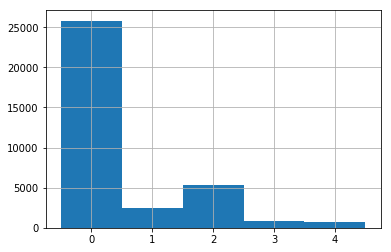

In [8]:
# Histograms on different 'level' values for diabetic retinopathy, 0 being no symptoms and 1-4 showing symptoms.
df['level'].hist(bins = [0,1,2,3,4,5], align = 'left');

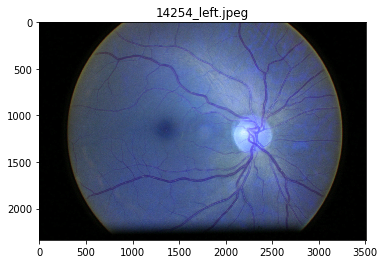

In [9]:
# Reading image 11344
train_dir = "A:/Downloads/retinopathy-dataset-master/train/train/"
a = cv2.imread(train_dir + df['image'][11344] + '.jpeg')
plt.imshow(a)
plt.title(df['image'][11344] + '.jpeg')
plt.show()

# Training and validation generators

Here we create the image data generator and the generators for the data. I wanted to use binary classification as seen in Demo 04 here, but I had trouble getting it to work.

In [10]:
# Creating image data generator
datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split = 0.25)

# Creating training and validation generators
trainGenerator = datagen.flow_from_dataframe(
    dataframe = df, 
    directory = "A:/Downloads/retinopathy-dataset-master/train/train/",
    has_ext = False,
    x_col = "image", 
    y_col = "level", 
    class_mode = "categorical", 
    target_size = (100, 100), 
    batch_size = 32,
    subset = 'training')

validGenerator = datagen.flow_from_dataframe(
    dataframe = df, 
    directory = "A:/Downloads/retinopathy-dataset-master/train/train/",
    has_ext = False,
    x_col = "image", 
    y_col = "level", 
    class_mode = "categorical", 
    target_size = (100, 100), 
    batch_size = 32,
    subset = 'validation')

Found 1547 images belonging to 5 classes.
Found 515 images belonging to 5 classes.


# Sequential Model

I played around with models a lot more this time around.

In [25]:
# Creating a Sequential model with several Conv2D layers
model = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
# See: https://keras.io/getting-started/sequential-model-guide/ -> VGG-like convnet
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (100, 100, 3)))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (100, 100, 3)))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation = 'softmax'))

from keras import backend
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer = sgd,
             loss='categorical_crossentropy', 
              metrics = ["accuracy", "mse", rmse])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 32)        0         
__________

In [26]:
# Calculate how many batches are needed to go through whole train and validation set
STEP_SIZE_TRAIN = trainGenerator.n // trainGenerator.batch_size
STEP_SIZE_VALID = validGenerator.n // validGenerator.batch_size
N = 5 # Number of epochs

# Train and count seconds
from time import time
t1 = time()
h = model.fit_generator(generator = trainGenerator,
                    steps_per_epoch = 50, #STEP_SIZE_TRAIN,
                    validation_data = validGenerator,
                    validation_steps = 15, #STEP_SIZE_VALID,
                    epochs = N,
                    verbose = 2)
t2 = time()
elapsed_time = (t2 - t1)

# Print the total elapsed time and average time per epoch in format (hh:mm:ss)
from time import localtime, strftime
t_total = strftime('%H:%M:%S', localtime(t2 - t1))
t_per_e = strftime('%H:%M:%S', localtime((t2 - t1)/N))
print('Total elapsed time for {:d} epochs: {:s}'.format(N, t_total))
print('Average time per epoch:             {:s}'.format(t_per_e))

Epoch 1/5
 - 191s - loss: 0.8405 - acc: 0.7546 - mean_squared_error: 0.0808 - rmse: 0.2231 - val_loss: 1.0777 - val_acc: 0.5854 - val_mean_squared_error: 0.1128 - val_rmse: 0.2633
Epoch 2/5
 - 175s - loss: 0.8235 - acc: 0.7414 - mean_squared_error: 0.0810 - rmse: 0.2243 - val_loss: 1.0985 - val_acc: 0.5765 - val_mean_squared_error: 0.1124 - val_rmse: 0.3141
Epoch 3/5
 - 168s - loss: 0.7586 - acc: 0.7693 - mean_squared_error: 0.0740 - rmse: 0.2075 - val_loss: 1.1566 - val_acc: 0.5521 - val_mean_squared_error: 0.1179 - val_rmse: 0.2836
Epoch 4/5
 - 172s - loss: 0.7614 - acc: 0.7621 - mean_squared_error: 0.0749 - rmse: 0.2076 - val_loss: 1.1232 - val_acc: 0.5698 - val_mean_squared_error: 0.1152 - val_rmse: 0.3119
Epoch 5/5
 - 176s - loss: 0.7686 - acc: 0.7602 - mean_squared_error: 0.0753 - rmse: 0.2126 - val_loss: 1.1336 - val_acc: 0.5687 - val_mean_squared_error: 0.1157 - val_rmse: 0.3111
Total elapsed time for 5 epochs: 02:14:43
Average time per epoch:             02:02:56


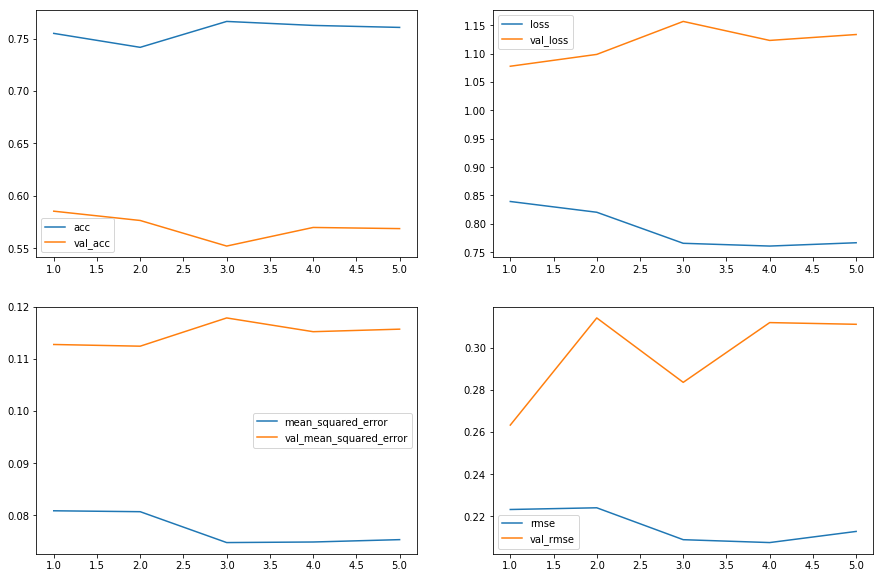

In [27]:
%matplotlib inline

epochs = np.arange(N) + 1.0

f, ax = plt.subplots(2, 2, figsize = (15,10))

def plotter(ax, epochs, h, variable):
    ax.plot(epochs, h.history[variable], label = variable)
    ax.plot(epochs, h.history['val_' + variable], label = 'val_'+variable)
    ax.legend()

plotter(ax[0][0], epochs, h, 'acc')
plotter(ax[0][1], epochs, h, 'loss')
plotter(ax[1][0], epochs, h, 'mean_squared_error')
plotter(ax[1][1], epochs, h, 'rmse')
plt.show()

In [52]:
# Calculate the true and predicted values
# If calculate to whole validation data set, delete/comment line 4 and remove steps from line 5
y_true = validGenerator.classes
y_true = y_true[:32*45] # Take only 20 steps, batch_size = 16
predict = model.predict_generator(validGenerator, steps = 45) # remove steps if calculate to whole dataset
y_pred = np.argmax(predict, axis = 1)

In [53]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report

cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:')
print(cm)
print('')

k = cohen_kappa_score(y_true, y_pred, weights = 'quadratic')
print("Quadratic weighted Cohen's kappa = {:.4f}".format(k))
print('')

cr = classification_report(y_true, y_pred)
print('Classification report:')
print(cr)
print('')

ValueError: Found input variables with inconsistent numbers of samples: [515, 1353]